In [1]:
# fit.py
import argparse
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm      
import matplotlib.pyplot as plt      

/Users/paddyslator/python/self-qmri/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATADIR = '/Users/paddyslator/Library/CloudStorage/OneDrive-UniversityCollegeLondon/data/low-field-placenta/scans/'


imgfilename = 'fm0034_ep2d_diff_zebr_g2_allb_denoised.nii.gz'
imgfilename = 'fm0037_ep2d_diff_zebr_g2_allb_denoised.nii.gz'
#imgfilename = 'fm0038_ep2d_diff_zebr_g2_allb_denoised.nii.gz'
#imgfilename = 'fm0039_ep2d_diff_zebr_g2_allb_denoised.nii.gz'
#imgfilename = 'fm0044_ep2d_diff_zebr_g2_allb_denoised.nii.gz'

gradfilename = 'grad_echo_fm0034.txt'
#gradfilename = 'grad_echo_fm0037.txt'
#gradfilename = 'grad_echo_fm0038.txt'
#gradfilename = 'grad_echo_fm0044.txt'
#gradfilename = 'grad_echo_fm0039.txt'

maskfilename = 'fm0034_ep2d_diff_zebr_g2_allb_placenta_and_uterine_wall_mask_pjs.nii.gz'
maskfilename = 'fm0037_ep2d_diff_zebr_g2_allb_placenta_and_uterine_wall_mask_pjs.nii.gz'
#maskfilename = 'fm0038_ep2d_diff_zebr_g2_allb_placenta_and_uterine_wall_mask_pjs.nii.gz'
#maskfilename = 'fm0039_ep2d_diff_zebr_g2_allb_placenta_and_uterine_wall_mask_pjs.nii.gz'
#maskfilename = 'fm0044_ep2d_diff_zebr_g2_allb_placenta_and_uterine_wall_mask_pjs.nii.gz'


imgnii = nib.load(DATADIR + imgfilename)
img = imgnii.get_fdata()

masknii = nib.load(DATADIR + maskfilename)
mask = masknii.get_fdata()

grad = np.loadtxt(DATADIR + gradfilename)

#scale the grad file
grad[:,3] = 1e-3*grad[:,3]
grad[:,4] = 1e-3*grad[:,4]




In [3]:
grad

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.117  ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.16101],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.20502],
       [-1.     , -0.     , -0.     ,  0.05   ,  0.117  ],
       [-0.     , -0.     , -1.     ,  0.05   ,  0.117  ],
       [ 0.     ,  1.     , -0.     ,  0.05   ,  0.117  ],
       [-1.     , -0.     , -0.     ,  0.05   ,  0.16101],
       [-0.     , -0.     , -1.     ,  0.05   ,  0.16101],
       [ 0.     ,  1.     , -0.     ,  0.05   ,  0.16101],
       [-1.     , -0.     , -0.     ,  0.05   ,  0.20502],
       [-0.     , -0.     , -1.     ,  0.05   ,  0.20502],
       [ 0.     ,  1.     , -0.     ,  0.05   ,  0.20502],
       [-1.     , -0.     , -0.     ,  0.1    ,  0.117  ],
       [-0.     , -0.     , -1.     ,  0.1    ,  0.117  ],
       [ 0.     ,  1.     , -0.     ,  0.1    ,  0.117  ],
       [-1.     , -0.     , -0.     ,  0.1    ,  0.16101],
       [-0.     , -0.     , -1.     ,  0.1    ,  0.16101

In [4]:
#preprocess data
from utilities.preprocessing import direction_average

#take the spherical mean
da_img,da_grad = direction_average(img,grad)



In [5]:
# #save the direction averaged image as nifti
# da_img_nii = imgnii
# da_img_nii.header = 
#imgnii.header['dim'][4]

In [6]:
#preprocess for machine learning! MAKE A FUNCTION OF THIS!

def img2voxel(img,mask):
    nvoxtotal = np.prod(np.shape(img)[0:3])
    nvol = np.shape(img)[3]
    #image in voxel format
    imgvox = np.reshape(img,(nvoxtotal,nvol))
    #mask in voxel format
    maskvox = np.reshape(mask,(nvoxtotal))
    #extract the voxels in the mask
    X_train = imgvox[maskvox==1]    
    
    return X_train,maskvox


X_train,maskvox = img2voxel(da_img,mask)

# nvoxtotal = np.prod(np.shape(img)[0:3])
# nvol = np.shape(img)[3]
# #image in voxel format
# imgvox = np.reshape(img,(nvoxtotal,nvol))
# #mask in voxel format
# maskvox = np.reshape(mask,(nvoxtotal))
# #extract the voxels in the mask
# X_train = imgvox[maskvox==1]

def normalise(X_train,grad):
    nvol = np.shape(grad)[0]
    
    #normalise 
    #find the volumes to normalise by - the lowest b-value lowest TE volume
    normvol = np.where((grad[:,3]==min(grad[:,3])) & (grad[:,4]==min(grad[:,4])))

    #X_train = X_train/(np.tile(np.mean(X_train[:,normvol], axis=2),(1, nvol)))
    X_train = X_train/(np.tile(np.mean(X_train[:,normvol], axis=1),(1, nvol)))
    
    return X_train


X_train = normalise(X_train,da_grad)
    

In [7]:
nparams = 3
#define the neural network - change to import this from elsewhere! 
class Net(nn.Module):
    def __init__(self, grad, nparams): #PASS MODEL STRING AS AN ARGUMENT IN HERE!
        super(Net, self).__init__()

        self.grad = grad
        self.fc_layers = nn.ModuleList()
        
        for i in range(nparams): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(grad.size(0), grad.size(0)), nn.ReLU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(grad.size(0), nparams))
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        D = torch.clamp(params[:, 0].unsqueeze(1), min = 0.01, max = 30)
        T2 = torch.clamp(params[:, 1].unsqueeze(1), min=0.001, max=1)
        #D = params[:, 0].unsqueeze(1)
        #T2 = params[:, 1].unsqueeze(1)
        bvals = self.grad[:,3]
        TE = self.grad[:,4]
        
        X = torch.exp(-bvals*D) * torch.exp(-(TE - torch.min(TE))/T2) 

        return X, D, T2


In [8]:

# make the Network
grad = torch.FloatTensor(da_grad)
net = Net(grad, nparams)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)  
#optimizer = optim.SGD(net.parameters(), lr = 0.01)  


#create batch queues
batch_size = 128
num_batches = len(X_train) // batch_size

#X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized

trainloader = utils.DataLoader(torch.from_numpy(X_train.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)


In [9]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

                
# Train
for epoch in range(100): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        X_pred, D_pred, T2_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████| 97/97 [00:01<00:00, 80.21it/s]


Loss: 10.762768924236298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████| 97/97 [00:00<00:00, 107.65it/s]


Loss: 9.708706445991993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████| 97/97 [00:00<00:00, 115.71it/s]


Loss: 8.648502610623837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████| 97/97 [00:00<00:00, 113.53it/s]


Loss: 7.721125543117523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████| 97/97 [00:00<00:00, 110.63it/s]


Loss: 7.013175584375858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████| 97/97 [00:00<00:00, 105.43it/s]


Loss: 6.696401834487915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


  0%|          | 0/97 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/site.py", line 73, in <module>
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 975, in get_code
  File "<frozen importlib._bootstrap_external>", line 1074, in get_data
KeyboardInterrupt
    import os
  File "/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/os.py", line 61, in <module>
    import posixpath as path
  File "/Users/paddyslator

In [ ]:
#Inference
net.eval()
with torch.no_grad():
    X, D, T2 = net(torch.from_numpy(X_train.astype(np.float32)))
    
D = D.numpy()
T2 = T2.numpy()


#convert parameters back to image format
D_vox = np.zeros(np.shape(maskvox))
D_vox[maskvox==1] = np.squeeze(D[:])
D_map = np.reshape(D_vox,np.shape(mask))

T2_vox = np.zeros(np.shape(maskvox))
T2_vox[maskvox==1] = np.squeeze(T2[:])
T2_map = np.reshape(T2_vox,np.shape(mask))



In [ ]:
#rotate images
from scipy import ndimage

D_map = ndimage.rotate(D_map,90,reshape=False)
T2_map = ndimage.rotate(T2_map,90,reshape=False)



(-0.5, 99.5, 99.5, -0.5)

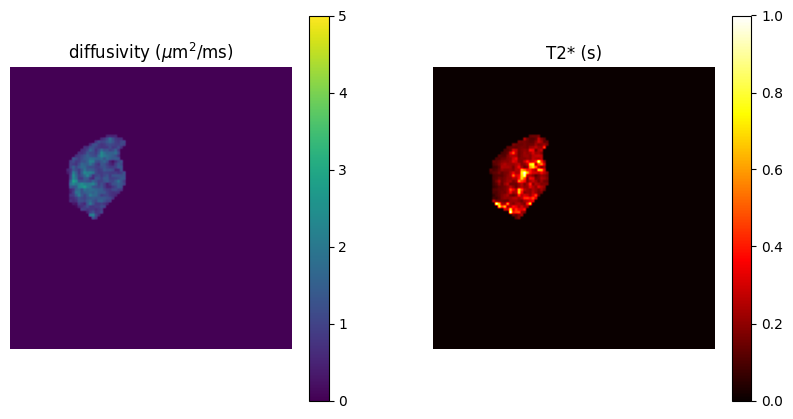

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,5))

zslice=30

plt0 = ax[0].imshow(D_map[:,:,zslice],vmin=0,vmax=5)
plt.colorbar(plt0,ax=ax[0])
ax[0].xaxis.set_ticklabels([]) 
ax[0].set_title('diffusivity ($\mu$m$^2$/ms)')
#ax[0].set_title('diffusivity (mm$^2$/ms)')
ax[0].axis('off')

plt0 = ax[1].imshow(T2_map[:,:,zslice],cmap='hot')
plt.colorbar(plt0,ax=ax[1])    
ax[1].xaxis.set_ticklabels([]) 
ax[1].set_title('T2* (s)')
ax[1].axis('off')
    
    
    

In [ ]:
#save the inferred maps as niftis
maps = np.stack((D_map, T2_map),axis=-1)

#use the image as a template
mapsnii = nib.Nifti1Image(maps, affine=imgnii.affine,header=imgnii.header)
#adjust 4th spatial dimension
mapsnii.header['dim'][4] = np.shape(maps)[-1]

nib.save(mapsnii, DATADIR + imgfilename[0:-7] + '_DT2_maps.nii.gz')  

#grad = np.loadtxt(args.grad[0])

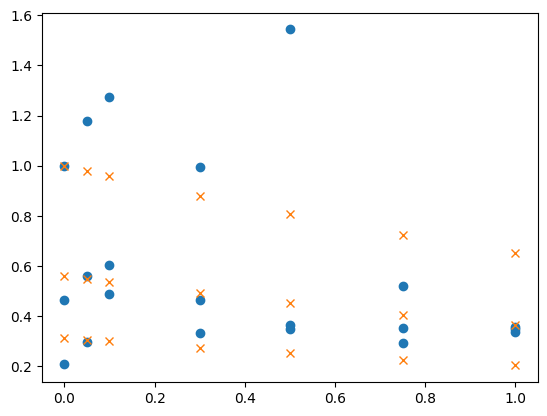

In [ ]:
plt.plot(grad[:,3],X_train[250,:],'o')
plt.plot(grad[:,3],X[250,:],'x')